# Digit Recognizer

## Import libraries

In [17]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch.nn as nn
import torch.optim as optim

## Load the dataset

In [18]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [19]:
train_dir = '/kaggle/input/digit-recognizer/train.csv'
test_dir = '/kaggle/input/digit-recognizer/test.csv'

In [20]:
df_train = pd.read_csv(train_dir, dtype=np.float32)
df_test = pd.read_csv(test_dir, dtype=np.float32)

In [21]:
df_train.shape

(42000, 785)

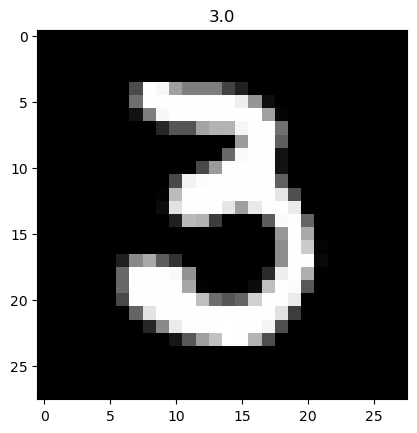

In [22]:
rand = np.random.randint(df_train.shape[0])
sample = df_train.iloc[rand, 1:].to_numpy().reshape(28, 28)
plt.imshow(sample, cmap='gray')
plt.title(df_train.iloc[rand, 0])
plt.show()


In [23]:
class MNIST(Dataset):
    def __init__(self, raw_data, test=False, transforms=None):
        self.raw_data = raw_data
        self.test = test
        self.transforms = transforms
    
    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, idx):
        if self.test:
            image = torch.tensor(self.raw_data.iloc[idx, :]).reshape(1, 28, 28)/255
            return image
        
        if self.transforms is not None: 
            image = self.transforms(torch.tensor(self.raw_data.iloc[idx, 1:]).reshape(1, 28, 28)/255)
            label = torch.tensor(self.raw_data.iloc[idx, 0], dtype=torch.uint8)
            return image, label
        
        image = torch.tensor(self.raw_data.iloc[idx, 1:]).reshape(1, 28, 28)/255
        label = torch.tensor(self.raw_data.iloc[idx, 0], dtype=torch.uint8)
        return image, label

In [24]:
transformations = transforms.Compose([transforms.RandomRotation((-15, 15)), transforms.ColorJitter()])
trainVal_data = MNIST(df_train, transforms=transformations)
test_data = MNIST(df_test, test=True)

In [25]:
train_data, val_data = torch.utils.data.random_split(trainVal_data, [35000,7000])

In [26]:
batch_size = 100

In [27]:
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

## Define the model

In [47]:
class Model(nn.Module) :
    def __init__(self) :
        super(Model, self).__init__()
        
        self.layer1 = nn.Sequential (
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential (
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential (
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc = nn.Sequential (
            nn.Linear(in_features=32*7*7, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )
    
    def forward(self, x) :
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Train

In [52]:
model = Model()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr)
epochs = 10

In [53]:
for epoch in range(epochs) :
    
    print(f"Starting training epoch {epoch+1}")
    
    sum_labels = torch.tensor([])
    sum_preds = torch.tensor([])
    val_labels = torch.tensor([])
    val_preds = torch.tensor([])
    
    model.train()
    for batch, data in enumerate(tqdm.tqdm(train_loader)) :
        
        images, labels = data
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(1)
        
        sum_labels = torch.cat([sum_labels, labels], dim=0)
        sum_preds = torch.cat([sum_preds, preds], dim=0)
    corr = sum_preds.eq(sum_labels).sum().item()
    print(f"epoch {epoch+1} accuracy = {corr/35000}")
    print()
    
    print(f"Starting validation epoch {epoch+1}")
    
    model.eval()
    for batch, data in enumerate(tqdm.tqdm(val_loader)):
        
        images, labels = data

        outputs = model(images)
        preds = outputs.argmax(1)
        val_labels = torch.cat([val_labels, labels], dim=0)
        val_preds = torch.cat([val_preds, preds], dim=0)
    corr = val_preds.eq(val_labels).sum().item()
    print(f"val {epoch+1} accuracy = {corr/7000}")
    print("-----------------------------------------")
    

Starting training epoch 1


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 1 accuracy = 0.8690857142857142

Starting validation epoch 1


  0%|          | 0/70 [00:00<?, ?it/s]

val 1 accuracy = 0.9605714285714285
-----------------------------------------
Starting training epoch 2


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 2 accuracy = 0.9682285714285714

Starting validation epoch 2


  0%|          | 0/70 [00:00<?, ?it/s]

val 2 accuracy = 0.9717142857142858
-----------------------------------------
Starting training epoch 3


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 3 accuracy = 0.9776285714285714

Starting validation epoch 3


  0%|          | 0/70 [00:00<?, ?it/s]

val 3 accuracy = 0.9797142857142858
-----------------------------------------
Starting training epoch 4


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 4 accuracy = 0.9818571428571429

Starting validation epoch 4


  0%|          | 0/70 [00:00<?, ?it/s]

val 4 accuracy = 0.9792857142857143
-----------------------------------------
Starting training epoch 5


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 5 accuracy = 0.9837428571428571

Starting validation epoch 5


  0%|          | 0/70 [00:00<?, ?it/s]

val 5 accuracy = 0.9835714285714285
-----------------------------------------
Starting training epoch 6


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 6 accuracy = 0.9864285714285714

Starting validation epoch 6


  0%|          | 0/70 [00:00<?, ?it/s]

val 6 accuracy = 0.9805714285714285
-----------------------------------------
Starting training epoch 7


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 7 accuracy = 0.9875142857142857

Starting validation epoch 7


  0%|          | 0/70 [00:00<?, ?it/s]

val 7 accuracy = 0.9808571428571429
-----------------------------------------
Starting training epoch 8


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 8 accuracy = 0.9888

Starting validation epoch 8


  0%|          | 0/70 [00:00<?, ?it/s]

val 8 accuracy = 0.9807142857142858
-----------------------------------------
Starting training epoch 9


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 9 accuracy = 0.9906571428571429

Starting validation epoch 9


  0%|          | 0/70 [00:00<?, ?it/s]

val 9 accuracy = 0.9844285714285714
-----------------------------------------
Starting training epoch 10


  0%|          | 0/350 [00:00<?, ?it/s]

epoch 10 accuracy = 0.9918857142857143

Starting validation epoch 10


  0%|          | 0/70 [00:00<?, ?it/s]

val 10 accuracy = 0.9877142857142858
-----------------------------------------


## Test and Submit

In [54]:
model.eval()
with torch.no_grad() :
    test_preds = torch.tensor([], dtype=torch.uint8)
    for _, images in enumerate(test_loader) :
        outputs = model(images)
        preds = outputs.argmax(1)
        test_preds = torch.cat([test_preds, preds], dim=0)

In [55]:
sub = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sub['Label'] = test_preds
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [56]:
sub.to_csv("submission.csv", index=False)